# CVA calculation for an Interest Rate Swap

In this report we show how to calculate the Credit Valuation Adjustment (CVA) taken by Counterparty 'A' to the price of an Interest Rate Swap (IRS) using the credit spreads for Counerparty B.

The inputs for the CVA calculation are:

* Forward LIBORs
* Discounting Factors
* Default Probabilities (PDs)

Below we discuss each of these aspects separately

Additional assumptions for this calculation are:

* The IRS is assumed to be written on a 6M LIBOR $L_{6M}$ expiring in 5Y, hence the payment frequency is $\tau=0.5$
* The notional is assumed to be $N=1$

## Default Probabilities

These are implied from CDS spreads using the bootstrapping technique.

### CDS bootstrapping

* The counterparty B in this case is chosen to be an airline company - AirFrance ("AIRF")
* The CDS spreads data was taken from Reuters on 27-Jun-2016
* The Recovery Rate (RR) is assumed to be 40%
* Linear interpolation is used to approximate the CDS spreads at the half increments for which there's no market data
* Discount factors have been approximated from the OIS spot curve data on 31-May-2016 (found here [ukois16_mdaily.xlsx](http://www.bankofengland.co.uk/statistics/Documents/yieldcurve/ukois16_mdaily.xlsx))
* All relevant calculations can be found in the sheet "_CVA/my CDS Bootstrapping v2.xlsx_"

The numerical inputs and results are summarised in the table below.

| Tenor (Years) |  AIRF CDS spread (bps) |                       Discount Factor (OIS) |  Lambda | PD (def. prob) | P (surv. prob) |
|--------------:|-----------------------:|--------------------------------------------:|--------:|---------------:|---------------:|
|           0.5 |                114.40  |                                   0.997885  | 1.8976% |        0.9443% |       99.0557% |
|           1.0 |                133.77  |                                   0.995749  | 2.2193% |        1.2505% |       97.8052% |
|           1.5 |                167.18  |                                   0.993131  | 2.7779% |        1.8864% |       95.9187% |
|           2.0 |                200.59  |                                   0.990013  | 3.3415% |        2.3833% |       93.5354% |
|           2.5 |                233.97  |                                   0.986480  | 3.9114% |        2.8510% |       90.6844% |
|           3.0 |                267.34  |                                   0.982581  | 4.4903% |        3.2875% |       87.3970% |
|           3.5 |                296.55  |                                   0.978317  | 5.0050% |        3.4658% |       83.9312% |
|           4.0 |                325.75  |                                   0.973660  | 5.5312% |        3.7794% |       80.1518% |
|           4.5 |                353.20  |                                   0.968578  | 6.0375% |        3.9425% |       76.2092% |
|           5.0 |                380.65  |                                   0.963044  | 6.5591% |        4.1697% |       72.0396% |

The below figures show the term structure of the period default probability $PD(T_i, T_{i-1}) = P(T_{i-1}) - P(T_i)$, the hazard rates $\lambda_i$ and the cumulative distributions for the default and survival probabilities.

![](PD/figs/PD.PNG)
![](PD/figs/lambda.PNG)
![](PD/figs/cum_PD.PNG)

## Forward LIBORs

The Forward LIBOR is obtained here by simulating the forward curves using the HJM model. However, this has to be calibrated to recent data to give a more realistic picture of the CVA value. This requires hence updating the dataset that runs the Principal Component Analysis (PCA).

Specifically the steps taken are described below.

### PCA

In [9]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#### Dataset

The HJM volatility functions for the model are estimated using Principal Component Analysis (PCA) using as input recent Bank of England Bank Liability Curve (BLC) data

* 3 years of recent BLC forward curve data (31-May-2013 to 31-May-2016) is taken from these 2 files
    * http://www.bankofengland.co.uk/statistics/Documents/yieldcurve/ukblc16_mdaily.xlsx 
    * http://www.bankofengland.co.uk/statistics/Documents/yieldcurve/ukblc05_mdaily.xlsx
This amounts to 759 data points

* Although we only need the short-end of the curve for the CVA calculation, we take the full curve to calibrate the HJM model, i.e. for up the $25Y$ tenor. The dataset is hence constructed by taking the BLC forward curve short-end data (_"1. fwds,short end"_ tab) for the tenors  $[0.5Y, 1.0Y, 1.5Y, ..., 5Y]$ as it offers a better approximation to the short-end, and for the remaining tenors $[5.5Y, ..., 25.0Y]$ we use the full approximation (_"2. fwd curve"_ tab)

* The forward rate for the tenor $0.08Y$ in _"1. fwds,short end"_ is used as a a proxy for the short rate tenor $0.0Y$, i.e. $r(t) = f(t;t)$

* Dates with missing data values were removed

* The resulting dataset is found in the project reporsitory under "_CVA/PCA/my_ukblc_310513_310516.xlsx_" and this was pasted into the "data" tab of "_HJM Model - PCA.XLSM_" to run the PCA


The plots below show the historical forward curve for 3 example rows in the dataset

In [8]:
df = pd.read_excel("PCA/my HJM Model - PCA.xlsm", sheetname="Data", index_col=0)

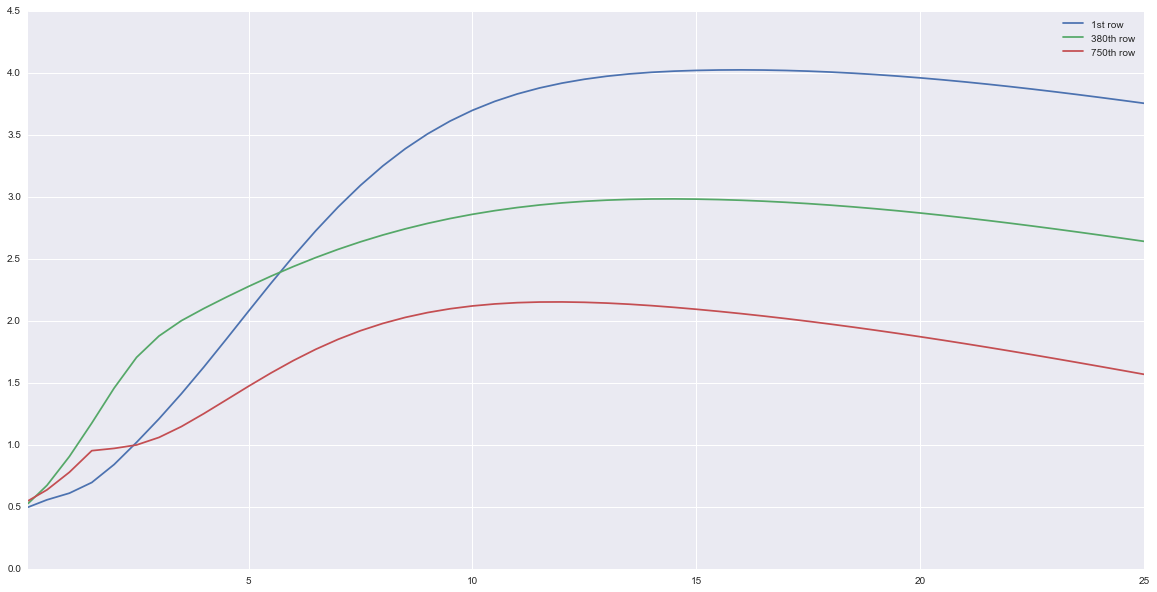

In [31]:
_ = df.iloc[0, :].plot(figsize=(20, 10), label="1st row")
_ = df.iloc[379, :].plot(figsize=(20, 10), label="380th row")
_ = df.iloc[749, :].plot(figsize=(20, 10), label="750th row")
_ = plt.legend()

The plots below show the historical rate for 3 example tenors. The $0.08Y$ tenor is a proxy for the spot rate

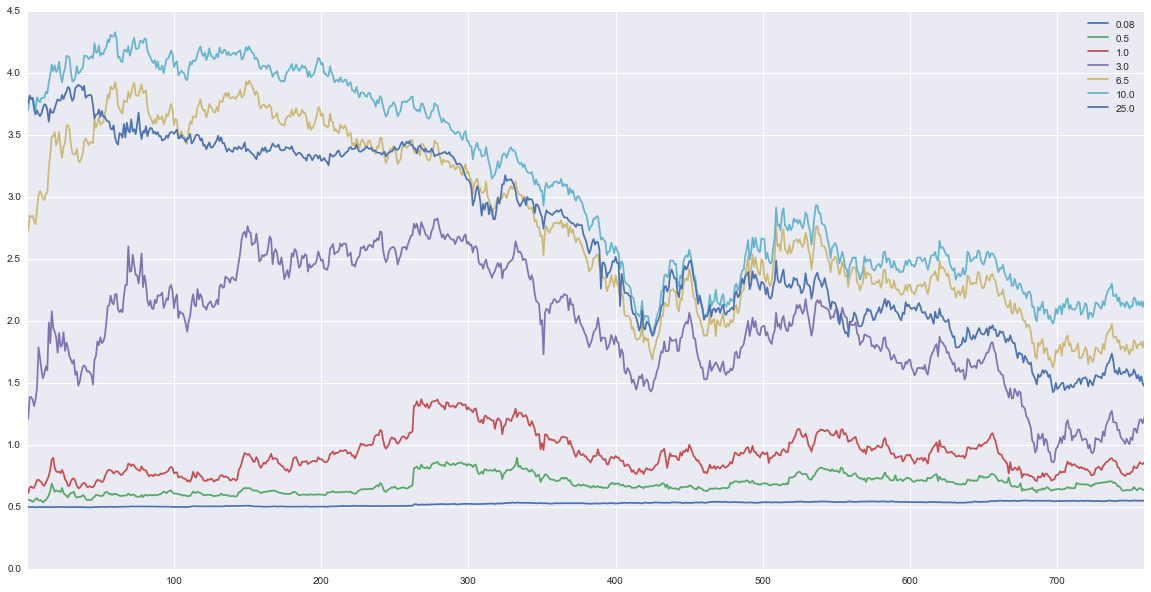

In [39]:
_ = df[0.08].plot(figsize=(20, 10))
_ = df[0.5].plot(figsize=(20, 10))
_ = df[1.0].plot(figsize=(20, 10))
_ = df[3.0].plot(figsize=(20, 10))
_ = df[6.5].plot(figsize=(20, 10))
_ = df[10.0].plot(figsize=(20, 10))
_ = df[25.0].plot(figsize=(20, 10))
_ = plt.legend()

#### Principal Components

The day-on-day change (differences) for each tenor is then obtained to produce a set of independent random variables to calculate the Covariance matrix and then the PCA. The 3 largest eigenvalues and corresponding eigenvectors are selected as they are enough to explain 97.5% of the observed variance as shown in the table below

|             | Tenor | Eigenvalue | Cum. R^2 |
|-------------|-------|------------|----------|
| 1st largest | 10.0  | 0.0076790  | 0.9107   |
| 2nd largest | 3.0   | 0.0004034  | 0.9586   |
| 3rd largest | 6.5   | 0.0001406  | 0.9752   |

The plot of their eigenvectors (principal components) is shown below:

![](PCA/figs/eigenvectors2.PNG)

### HJM 

#### Volatility functions

The volatility functions for the HJM model are calculated by 
$$
Vol_i = \sqrt{\lambda_i} \space e(i) \space\space\space \forall \space i=1,2,3
$$
This is equivalent to one standard deviation move in the $e(i)$ direction.

These are then fitted since we need analytical functions to carry out the integration to get the drift. In this case, 3rd, 5th and 6th degree polynomials were fitted to guarantee a goodness of fit of over 97%. These are show in the figures below. In particular, for $Vol_{1}$ the constant fit shown is clearly not suited and justifies the need for a polynomial fit (however, this could also lead to overfitting issues)

![](PCA/figs/Vol_1.PNG)
![](PCA/figs/Vol_2.PNG)
![](PCA/figs/Vol_3.PNG)

Lastly, the drift function is obtained by integrating over the principal components and assuming that volatility is  function of time in the HJM model

### Monte Carlo

The calibrated volatility and drift functions above are then entered into the HJM model Monte Carlo simulation in "my_HJM_model.py", which evolves the whole forward curve according to the SDE:
$$
d\bar{f} = \mu (t) dt + \sum_{i=1}^{3} Vol_i \phi_i \sqrt{dt} + \frac{dF}{d\tau} dt
$$

where $\phi_i$ is a random number drawn from the standard normal distribution.

Additional details of the MC simulation:

* Python 2.7 was used in the python script
* The forward curve was initialised using the the last observed forward curve data (last row in the BLC data)
* Time step $dt = 0.01$
* Number of simulations $I = 1,000$
* The random number generator used is python's numpy standard normal random number generator ('np.random.standard_normal') which draw samples from a standard Normal distribution (mean=0, stdev=1)
* The antithetic variance reduction technique is used to reduce the simulation error as minimal computational cost

To obtain an expectation of LIBOR rate in the future $L(t; T_i, T_{i+1})$, the rate is selected from the corresponding tenor column $\tau = T_{i+1} - T_i$ of the HJM output of forward rates, from the correct simulated time $t$. We then convert to the simple annualised rate using $L = \frac{1}{\tau}(e^{f\tau}-1)$